Gravitational Wave Kaggle Challenge

In [24]:
#Load Packages
%load_ext autoreload
%autoreload 2
%matplotlib inline

#Basic Packages
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import math

#Machine Learning
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Deep Learning
#NN Model
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Activation, Conv2D, Flatten 
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
#Preprpocessing and Utilities
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import load_model
#Trained Networks
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import MobileNet

#Special Kit for Torch Audio
import torch
from nnAudio.Spectrogram import CQT1992v2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
#tf.config.list_physical_devices('GPU')
tf.config.experimental.list_physical_devices('GPU')

[]

In [4]:
df_train_data = pd.read_csv('training_labels.csv')

In [5]:
def get_train_file_path(image_id):
    return "Train/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

df_train_data['file_path'] = df_train_data['id'].apply(get_train_file_path)

In [6]:
ssp = StratifiedShuffleSplit(n_splits=10, random_state=None)

dict_KFold={}
ix=0
for a_idx, b_idx in ssp.split(df_train_data['id'],df_train_data['target']):
    dict_KFold[ix]=b_idx
    ix=ix+1

Text(0.5, 1.0, 'Fold Indices N = 56000/Fold')

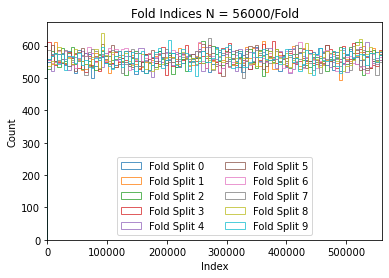

In [7]:
for fold in range(len(dict_KFold)):
    plt.hist(dict_KFold[fold], 100, density=False, facecolor='b', 
                            alpha=0.75, cumulative=False, histtype='step',
                            label='Fold Split {}'.format(fold))
plt.xlabel('Index')
plt.xlim(0,len(df_train_data))
plt.ylabel('Count')
plt.legend(loc='lower center', ncol=2)
plt.title('Fold Indices N = {}/Fold'.format(len(dict_KFold[0])))

In [8]:
fold_balance=[]
for fold in range(len(dict_KFold)):
    df_fold = df_train_data.loc[dict_KFold[fold]]
    fold_balance.append(df_fold['target'].mean())
fold_balance

[0.499875,
 0.499875,
 0.499875,
 0.499875,
 0.499875,
 0.499875,
 0.499875,
 0.499875,
 0.499875,
 0.499875]

In [9]:
# Train on one fold
fold = 9
df_fold = df_train_data.loc[dict_KFold[fold]]

df_train, df_vp = train_test_split(
    df_fold, 
    test_size=0.1, 
    random_state=14,
    stratify=df_fold["target"],
)
num_valid = int(len(df_vp)*.2)
df_valid = df_vp.iloc[:num_valid]
df_predict = df_vp.iloc[num_valid:]

Visualize waveforms here

In [10]:
def visualize_sample(
    _id, 
    pathx,
    target,
    signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo"),
    sr=2048,
):
    x = np.load(pathx)
    fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(5,7),constrained_layout=True)
    fig.suptitle('id: {}, Target={}'.format(_id, target), fontsize=16)
    for i in range(3):
        waves = x[i] / np.max(x[i])
        ax[i].plot(waves, color='k')
        ax[i].set_title(signal_names[i], fontsize=14)
        #ax[i].set_xticks(xbins)
        #ax[i].set_xticklabels(binstime)
        ax[i].set_ylabel('Normalized Amplitude')
        ax[1].set_xlabel('Time [ms]')
    return()
    fig.suptitle(f"id: {_id}  -----  Target: {target}", fontsize=16)
    fig.tight_layout()

()

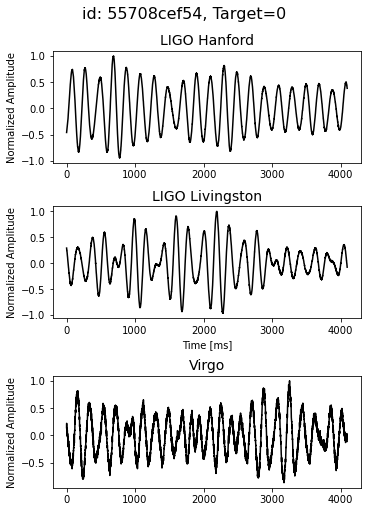

In [11]:
visualize_sample(df_train.iloc[2]["id"],df_train.iloc[2]["file_path"],df_train.iloc[2]["target"])

In [12]:
Q_TRANSFORM = CQT1992v2(sr=2048, fmin=22, n_bins=32, bins_per_octave=8, 
                        hop_length=16)

CQT kernels created, time used = 0.0151 seconds


In [77]:
def visualize_sample_qtransform(
    _id, 
    pathx,
    target,
    signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo"),
    sr=2048,
):
    #Wave Conversions
    waves = np.load(pathx)
    amaxw = np.max(waves)
    wave0 = waves[0,:]/amaxw
    wave0 = torch.from_numpy(wave0).float()
    wave1 = waves[1,:]/amaxw
    wave1 = torch.from_numpy(wave1).float()
    wave2 = waves[2,:]/amaxw
    wave2 = torch.from_numpy(wave2).float()
    cqtw0 = Q_TRANSFORM(wave0)
    cqtw1 = Q_TRANSFORM(wave1)
    cqtw2 = Q_TRANSFORM(wave2)
    #Plotting Preliminaries
    #Frequency Y axis
    lenfrq = len(Q_TRANSFORM.frequencies)
    ybins = list(np.arange(0,lenfrq,4)) #bin values
    binsfrq = np.round(Q_TRANSFORM.frequencies,1)[0::4] #every 4th
    binsfrq = ["%.1f" % number for number in binsfrq] #covvert to string
    # time steps X axis
    nxbins = cqtw0.shape[2]
    xbins = list(np.arange(0,nxbins+1,32))
    binstime = np.arange(0,4096+1,32)[0::16]
    binstime = ["%.0f" % number for number in binstime]
    x = np.load(pathx)
    fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(5,8),
                           constrained_layout=True)
    fig.suptitle('id: {}, Shape={}, Target={}'.format(_id, (nxbins,lenfrq), target),
                 fontsize=14)
    #fig.tight_layout(pad=1, w_pad=.5,h_pad=2)
    for i in range(3):
        waves = x[i] / np.max(x[i])
        waves = torch.from_numpy(waves).float()
        image = Q_TRANSFORM(waves)
        v_min, v_max = torch.min(image), torch.max(image)
        image = (image - v_min)/(v_max - v_min)
        image = np.transpose(image,(1,2,0))
        
        #ax.subplot(3,1, i + 1)
        ax[i].imshow(image, interpolation='nearest', aspect='auto')
        ax[i].set_title(signal_names[i], fontsize=14)
        ax[i].set_yticks(ybins)
        ax[i].set_yticklabels(binsfrq)
        ax[i].set_xticks(xbins)
        ax[i].set_xticklabels(binstime)
        ax[i].set_ylabel('Frequency Bin')
        ax[i].set_xlabel('Time [ms]')
    return((nxbins, lenfrq), (xbins, ybins))
    
    fig.suptitle(f"id: {_id}  -----  Target: {target}", fontsize=16)
    fig.tight_layout()

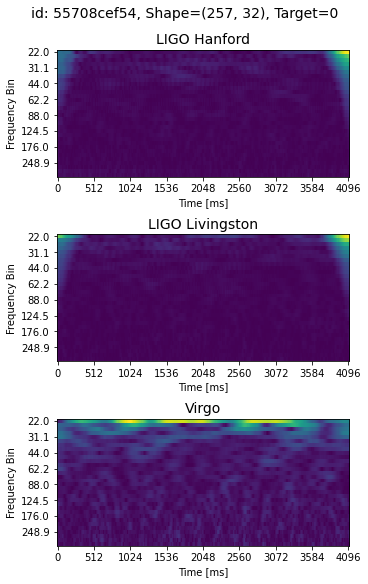

In [78]:
cwt_shape, plot_bins = visualize_sample_qtransform(df_train.iloc[2]["id"],df_train.iloc[2]["file_path"],df_train.iloc[2]["target"])

In [17]:
class Dataset(Sequence):
    def __init__(self,df,is_train=True,batch_size=32, shuffle=False):
        self.idx = df["id"].values
        self.paths = df["file_path"].values
        self.y =  df["target"].values
        self.is_train = is_train
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.wave_transform = CQT1992v2(sr=2048, fmin=22, n_bins=32, 
                                        bins_per_octave=8, hop_length=16)
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
    
    def apply_qtransform(self,pathx,transform): 
        waves = np.load(pathx)
        amaxw = np.max(waves)
        wave0 = waves[0,:]/amaxw
        wave0 = torch.from_numpy(wave0).float()
        wave1 = waves[1,:]/amaxw
        wave1 = torch.from_numpy(wave1).float()
        wave2 = waves[2,:]/amaxw
        wave2 = torch.from_numpy(wave2).float()
        cqtw0 = transform(wave0)
        cqtw1 = transform(wave1)
        cqtw2 = transform(wave2)
        image = torch.cat([cqtw0, cqtw1, cqtw2],dim=0)
        image.transpose_(0, 2)
        image.numpy()
        tf.convert_to_tensor(image, np.float32)
        return(image)
    
    def __getitem__(self,ids):
        batch_paths = self.paths[ids * self.batch_size:(ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
            
        list_x = [self.apply_qtransform(x,self.wave_transform) for x in batch_paths]
        batch_X = tf.stack(list_x)
        if self.is_train:
            return batch_X, batch_y
        else:
            return batch_X

In [55]:
clear_session()

In [56]:
train_dataset = Dataset(df_train, is_train=True, shuffle=False, batch_size=32)
valid_dataset = Dataset(df_valid, is_train=True, shuffle=False, batch_size=32)
predict_dataset = Dataset(df_predict)

CQT kernels created, time used = 0.0156 seconds
CQT kernels created, time used = 0.0000 seconds
CQT kernels created, time used = 0.0000 seconds


In [57]:
# %% Create Model mobile net
def create_model(cwt_shape): 
    
    inputs=InputLayer(input_shape=(*cwt_shape,3))
    
    dn_layers = DenseNet121(include_top=False, weights='imagenet',
                            input_shape=None)
    model = Sequential()
    
    model.add(inputs)
    model.add(dn_layers)
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))
    
    model.compile(optimizer= Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', metrics=['acc'])

    return model

model = create_model(cwt_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
dropout (Dropout)            (None, 8, 1, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8193      
Total params: 7,045,697
Trainable params: 6,962,049
Non-trainable params: 83,648
_________________________________________________________________


In [54]:
learning_rate = 0.0005
epochs = 5
run_name = 'DenseNet121'
early_stopping = EarlyStopping(monitor='val_loss' ,patience=5, verbose=1, mode='min')
#model_checkpoint = ModelCheckpoint("run_{}.h5".format(run_name), monitor='val_loss', mode='min', save_best_only=True)                                
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.33, patience=6, min_lr=1e-6, verbose=1, mode='min')

In [58]:
history = model.fit(train_dataset, epochs=epochs, steps_per_epoch=256,
                    validation_data=valid_dataset, validation_steps=32,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/5
256/256 [==============================] - 450s 2s/step - loss: 0.6292 - acc: 0.6749 - val_loss: 0.6643 - val_acc: 0.5742
Epoch 2/5
256/256 [==============================] - 448s 2s/step - loss: 0.4857 - acc: 0.7522 - val_loss: 0.6605 - val_acc: 0.6338
Epoch 3/5
256/256 [==============================] - 441s 2s/step - loss: 0.5018 - acc: 0.7443 - val_loss: 1.7959 - val_acc: 0.6631
Epoch 4/5
256/256 [==============================] - 430s 2s/step - loss: 0.4911 - acc: 0.7521 - val_loss: 0.4727 - val_acc: 0.7666
Epoch 5/5
256/256 [==============================] - 433s 2s/step - loss: 0.4815 - acc: 0.7627 - val_loss: 0.5002 - val_acc: 0.7549


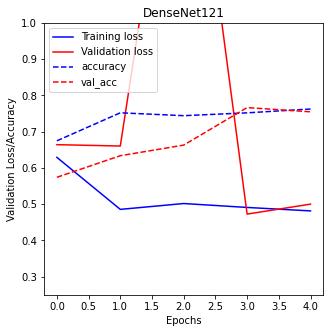

In [60]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(len(loss))
    fig, ax = plt.subplots(figsize=(5,5))
    #ax1=ax.twinx()
    ax.plot(epochs, loss, "b", label="Training loss")
    ax.plot(epochs, val_loss, "r", label="Validation loss")
    ax.plot(epochs, acc, 'b',linestyle='--', label='accuracy')
    ax.plot(epochs, val_acc, 'r', linestyle='--', label='val_acc')
    ax.set_title(title)
    ax.set_ylim([.25,1.00])
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Training")
    ax.set_ylabel('Validation Loss/Accuracy')
    ax.legend(loc='upper left')
    #ax1.legend(loc='right')
    plt.show()
# %%
visualize_loss(history,run_name)

In [62]:
test_predictions = model.predict(predict_dataset)

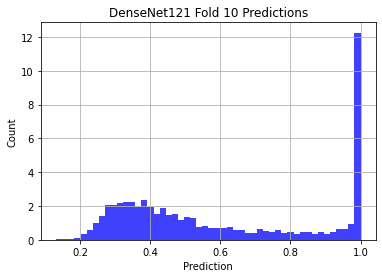

In [63]:
n, bins, patches = plt.hist(test_predictions, 50, density=True, facecolor='b', 
                            alpha=0.75, cumulative=False)

plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('{} Fold 10 Predictions'.format(run_name))

plt.grid(b=True, axis='both' ,which='major')
plt.show()

In [64]:
def split_df_predict(df_in):
    df_train, df_vp = train_test_split(
    df_fold, 
    test_size=0.05, 
    random_state=14, 
    stratify=df_fold["target"])
    num_valid = int(len(df_vp)*.8)
    df_valid = df_vp.iloc[:num_valid]
    df_predict = df_vp.iloc[num_valid:]
    return(df_predict)

In [65]:
dict_fpr={}
dict_tpr={}
dict_roc_auc={}
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold in range(len(dict_KFold)):

    df_fold = df_train_data.loc[dict_KFold[fold]]
    df_predict = split_df_predict(df_fold)
    predict_dataset = Dataset(df_predict)
    test_predictions = model.predict(predict_dataset)
    fpr, tpr, _ = roc_curve(df_predict['target'].values, test_predictions)
    roc_auc = auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    dict_fpr[fold]=fpr
    dict_tpr[fold]=tpr
    dict_roc_auc[fold]=roc_auc
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1]=1
mean_auc = auc(mean_fpr,mean_tpr)

CQT kernels created, time used = 0.0000 seconds
CQT kernels created, time used = 0.0000 seconds
CQT kernels created, time used = 0.0050 seconds
CQT kernels created, time used = 0.0000 seconds
CQT kernels created, time used = 0.0000 seconds
CQT kernels created, time used = 0.0000 seconds
CQT kernels created, time used = 0.0156 seconds
CQT kernels created, time used = 0.0050 seconds
CQT kernels created, time used = 0.0000 seconds
CQT kernels created, time used = 0.0050 seconds


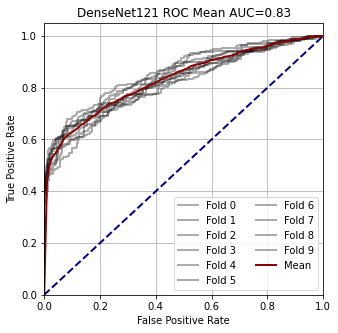

In [67]:
str_title='{} ROC Mean AUC={}'.format(run_name, np.round(mean_auc,2))
fig, ax = plt.subplots(figsize=(5,5))

for fold in range(len(dict_fpr)):
    
    ax.plot(dict_fpr[fold], dict_tpr[fold], color='k', alpha=.33,
         lw=2, label='Fold {}'.format(fold))
ax.plot(mean_fpr, mean_tpr, color='darkred', lw=2, label='Mean')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.grid(b=True, which='both')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(str_title)
ax.legend(loc="lower right", ncol=2)

In [68]:
# %% show examples of high confidence extremes
df_predict['Predictions'] = test_predictions
df_predict['wrong'] = df_predict['target'] - df_predict['Predictions']
idx_min_predict = 519767 #446115 DN
idx_max_predict = 118534 #DN8818 #118534 # 458509 #
idx_fn = 203606 #DNpredict .81 181293 
idx_fp = 208653 #DN predict .094 203651

(257, 32)

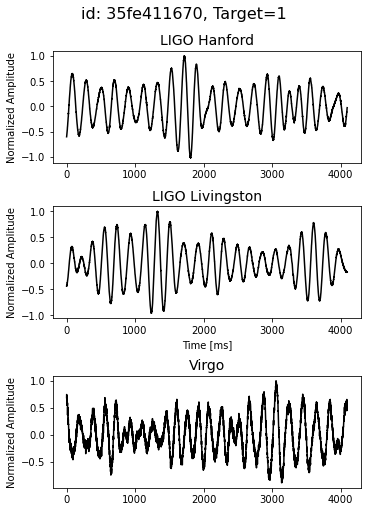

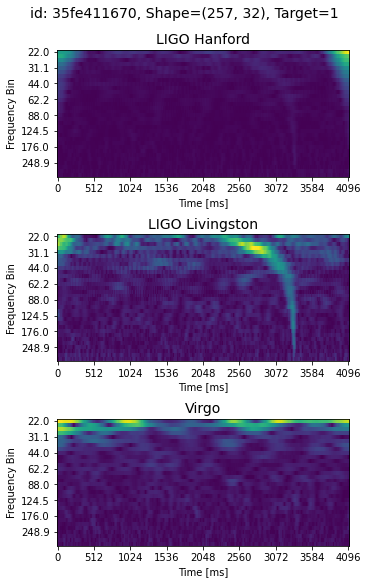

In [69]:
# %% plot waveforms from True
visualize_sample(df_train_data.iloc[idx_max_predict]["id"],
                 df_train_data.iloc[idx_max_predict]["file_path"],
                 df_train_data.iloc[idx_max_predict]["target"])

visualize_sample_qtransform(df_train_data.iloc[idx_max_predict]["id"],
                 df_train_data.iloc[idx_max_predict]["file_path"],
                 df_train_data.iloc[idx_max_predict]["target"])

(257, 32)

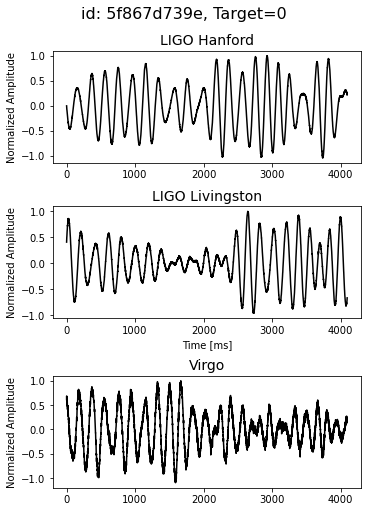

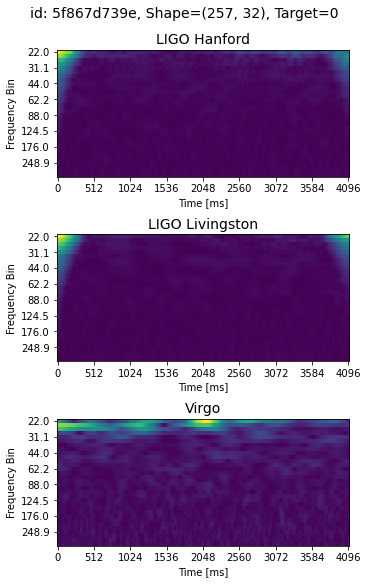

In [70]:
# %% plot waveforms from false positive
visualize_sample(df_train_data.iloc[idx_fp]["id"],
                 df_train_data.iloc[idx_fp]["file_path"],
                 df_train_data.iloc[idx_fp]["target"])

visualize_sample_qtransform(df_train_data.iloc[idx_fp]["id"],
                 df_train_data.iloc[idx_fp]["file_path"],
                 df_train_data.iloc[idx_fp]["target"])

In [72]:
# %% stacked image based on df filter 10/24/2021
test_predictions = model.predict(predict_dataset)
df_predict['Predictions'] = test_predictions
df_predict['wrong'] = df_predict['target'] - df_predict['Predictions']
df_True = df_predict[df_predict.Predictions == 1]

In [80]:
def qtransform_3channel(
    _id, 
    pathx,
    target,
    signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo"),
    sr=2048,
):
    waves = np.load(pathx)
    amaxw = np.max(waves)
    wave0 = waves[0,:]/amaxw
    wave0 = torch.from_numpy(wave0).float()
    wave1 = waves[1,:]/amaxw
    wave1 = torch.from_numpy(wave1).float()
    wave2 = waves[2,:]/amaxw
    wave2 = torch.from_numpy(wave2).float()
    cqtw0 = Q_TRANSFORM(wave0)
    cqtw1 = Q_TRANSFORM(wave1)
    cqtw2 = Q_TRANSFORM(wave2)
    #Frequency Y axis
    lenfrq = len(Q_TRANSFORM.frequencies)
    ybins = list(np.arange(0,lenfrq,4)) #bin values
    binsfrq = np.round(Q_TRANSFORM.frequencies,1)[0::4] #every 4th
    binsfrq = ["%.1f" % number for number in binsfrq] #covvert to string
    # time steps X axis
    nxbins = cqtw0.shape[2]
    xbins = list(np.arange(0,nxbins+1,32))
    binstime = np.arange(0,4096+1,32)[0::16]
    binstime = ["%.0f" % number for number in binstime]
    
    v_min, v_max = torch.min(cqtw0), torch.max(cqtw0)
    im0 = (cqtw0 - v_min)/(v_max - v_min)
    im0 = np.transpose(im0,(1,2,0)).numpy()
    v_min, v_max = torch.min(cqtw1), torch.max(cqtw1)
    im1 = (cqtw1 - v_min)/(v_max - v_min)
    im1 = np.transpose(im1,(1,2,0)).numpy()
    v_min, v_max = torch.min(cqtw2), torch.max(cqtw2)
    im2 = (cqtw2 - v_min)/(v_max - v_min)
    im2 = np.transpose(im2,(1,2,0)).numpy()
    
    return(im0, im1, im2, (xbins, ybins), (binstime,binsfrq))

In [88]:
list_im0=[]
list_im1=[]
list_im2=[]

for row in df_True.iterrows():
    #[0 is index, 1 is series]
    _id=row[1]['id']
    pathx = row[1]['file_path']
    target = row[1]['target']
    list_im0.append(qtransform_3channel(_id,pathx,target)[0])
    list_im1.append(qtransform_3channel(_id,pathx,target)[1])
    list_im2.append(qtransform_3channel(_id,pathx,target)[2])
*_, plot_bins, bin_labels = qtransform_3channel(_id, pathx, target)

# %%
img0 = np.mean(np.concatenate(list_im0, -1), axis=2)
img1 = np.mean(np.concatenate(list_im1, -1), axis=2)
img2 = np.mean(np.concatenate(list_im2, -1), axis=2)

img0 = np.where(img0>.1,0,img0)
img1 = np.where(img1>.1,0,img0)
img2 = np.where(img2>.1,0,img0)

imgs = [img0, img1, img2]
signal_names=["LIGO Hanford", "LIGO Livingston", "Virgo"]


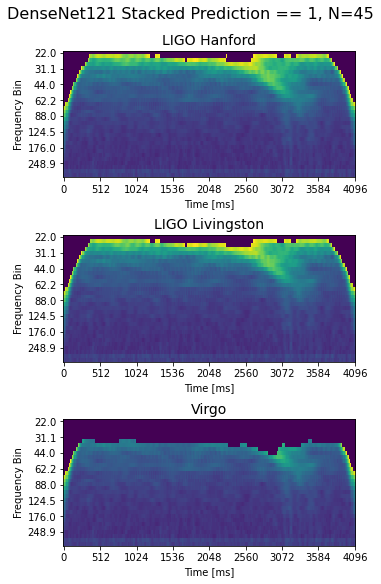

In [89]:
# %% plot stack
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(5,8),constrained_layout=True)
fig.suptitle('{} Stacked Prediction == 1, N={}'.format(run_name, len(list_im0)), fontsize=16)
for ix, (img, signal) in enumerate(zip(imgs, signal_names)):
    ax[ix].imshow(img, interpolation='nearest', aspect='auto')
    ax[ix].set_title(signal, fontsize=14)
    ax[ix].set_yticks(plot_bins[1])
    ax[ix].set_yticklabels(bin_labels[1])
    ax[ix].set_xticks(plot_bins[0])
    ax[ix].set_xticklabels(bin_labels[0])
    ax[ix].set_ylabel('Frequency Bin')
    ax[ix].set_xlabel('Time [ms]')   


In [90]:
model_niv = load_model('run_DenseNet_PrePreprocess3.h5')

In [95]:
featuremap_dataset = Dataset(df_True.iloc[0:32,:])

CQT kernels created, time used = 0.0156 seconds


In [96]:
layer_nested=[layer.name for layer in model_niv.layers[0].layers]

model_fm9 = Model(inputs=model_niv.layers[0].inputs, outputs=model_niv.layers[0].layers[9].output)
model_fm93 = Model(inputs=model_niv.layers[0].inputs, outputs=model_niv.layers[0].layers[93].output)

In [97]:
feature_activations9 = model_fm9.predict(featuremap_dataset)
feature_activations93 = model_fm93.predict(featuremap_dataset)

In [98]:
feature_activations9 = np.transpose(feature_activations9, [0,2,1,3])
feature_activations93 = np.transpose(feature_activations93, [0,2,1,3])

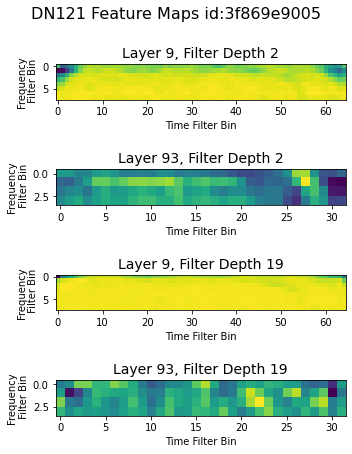

In [100]:
id_name = df_True.iloc[0]['id']
filter_num1 = 2
filter_num2 = 19
layer_names=['Layer 9, Filter Depth {}'.format(filter_num1),
             'Layer 93, Filter Depth {}'.format(filter_num1),
             'Layer 9, Filter Depth {}'.format(filter_num2),
             'Layer 93, Filter Depth {}'.format(filter_num2)]

imgs = [feature_activations9[0,:,:,filter_num1],feature_activations93[0,:,:,filter_num1],
        feature_activations9[0,:,:,filter_num2],feature_activations93[0,:,:,filter_num2]
       ]

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(5,7)) 
fig.suptitle('DN121 Feature Maps id:{}'.format(id_name), fontsize=16)
for ix, (img, lt) in enumerate(zip(imgs, layer_names)):
    #ax.subplot(3,1, i + 1)
    ax[ix].imshow(img, interpolation='nearest') #interpolation='nearest', aspect='auto'
    ax[ix].set_title(lt, fontsize=14)
    
    ax[ix].set_ylabel('Frequency\n Filter Bin')
    ax[ix].set_xlabel('Time Filter Bin')   
fig.tight_layout(h_pad=-6)
plt.subplots_adjust(top=1)

In [ ]:
#Next try cropping input image frqmin = 32, frqmax = 320, tmin 2048, tmax= 3600
#Try Larger conv filter
#Try 3D model
#Write one fold out to another directory